# `race_winner_bet_random_walk_odds_baseline.ipynb`

### Author: Anthony Hein

#### Last updated: 12/7/2021

# Overview:

Computes the performance of a baseline for selecting a race winner which selects the one with the better odds. When the odds are equal, the baseline selects either horse with equal probability.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_clean.csv`

In [3]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean_augmented.csv",
                           low_memory=False)
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,OR,father,mother,gfather,weight,res_win,res_place,res_show,finishing time,finishing time ratio
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0,277.200000,1.000000
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0,278.679948,1.005339
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,Nordico,Over The Seas,North Summit,71,0,0,0,278.957438,1.006340
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0,284.507242,1.026361
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0,290.057045,1.046382


In [4]:
list(horses_clean.columns)

['rid',
 'horseName',
 'age',
 'saddle',
 'decimalPrice',
 'isFav',
 'trainerName',
 'jockeyName',
 'position',
 'positionL',
 'dist',
 'outHandicap',
 'RPR',
 'TR',
 'OR',
 'father',
 'mother',
 'gfather',
 'weight',
 'res_win',
 'res_place',
 'res_show',
 'finishing time',
 'finishing time ratio']

In [5]:
horses_clean = horses_clean[['rid', 'horseName', 'decimalPrice', 'position', 'res_win']]

In [6]:
horses_clean.shape

(202304, 5)

---

## Load `races_selected_trimmed_clean.csv`

In [7]:
races_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/races_selected_trimmed_clean.csv", low_memory=False)
races_clean.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,station name,station lat,station lng,dist to station,station reading date,temp,msl,rain,rhum,station reading timedelta
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,BIRR,53.0525,-7.5325,45.288813,1/9/97 12:00,1.6,1012.4,0.0,87,15.0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,CASEMENT,53.1820,-6.2620,24.477602,2/16/97 15:00,8.0,992.5,0.4,87,20.0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,SHANNON AIRPORT,52.4125,-8.5505,63.534139,3/1/97 14:00,12.0,1003.5,0.0,73,0.0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,CASEMENT,53.1820,-6.2620,24.477602,4/24/97 14:00,12.6,1011.9,0.0,72,20.0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,SHANNON AIRPORT,52.4125,-8.5505,25.222137,5/8/97 17:00,11.1,994.2,0.0,59,30.0


In [8]:
races_clean.shape

(20201, 34)

---

## Load Identifying Info

In [9]:
X_train_identifiers = pd.read_csv(f"{BASE_DIR}/data/analysis/X_train_identifiers.csv", low_memory=False)
X_train_identifiers.head()

,rid,horse1_horseName,horse2_horseName
0,341451,Dance Design,Idris
1,341451,Idris,Dance Design
2,50025,Azra,Johan Cruyff
3,50025,Azra,Beautiful Fire
4,50025,Johan Cruyff,Azra


In [10]:
X_dev_identifiers = pd.read_csv(f"{BASE_DIR}/data/analysis/X_dev_identifiers.csv", low_memory=False)
X_dev_identifiers.head()

,rid,horse1_horseName,horse2_horseName
0,159686,Gussy Goose,Ibergman
1,159686,Mothers Finest,Emergent
2,159686,Mothers Finest,Gussy Goose
3,159686,Mothers Finest,Just Joan
4,159686,Mothers Finest,Rayisa


In [11]:
X_test_identifiers = pd.read_csv(f"{BASE_DIR}/data/analysis/X_test_identifiers.csv", low_memory=False)
X_test_identifiers.head()

,rid,horse1_horseName,horse2_horseName
0,136782,Sestriere,Associate Rock
1,136782,Sestriere,Fridtjof Nansen
2,136782,Sestriere,Pillar
3,136782,Sestriere,Captain Power
4,136782,Sestriere,Frow


---

## Find Races w/ All Runners Present

In [12]:
def runners_to_num_pairs(runners: int) -> int:
    """
    Calculates the number of 2-tuple permutations
    for a given amount runners.
    """
    return runners * (runners - 1)

In [13]:
def find_races_all_runners_present(df: pd.core.frame.DataFrame) -> List[int]:
    df = df.groupby("rid").count()
    df = df.merge(races_clean[['rid', 'runners']], on='rid')
    df['permutations'] = df['runners'].map(runners_to_num_pairs)
    return list(df[df['permutations'] == df['horse1_horseName']]['rid'])

Check the function:

In [14]:
find_races_all_runners_present(X_train_identifiers)[0]

330

In [15]:
len(X_train_identifiers[X_train_identifiers['rid'] == 330])

56

In [16]:
races_clean[races_clean['rid'] == 330].iloc[0]['runners']

8

In [17]:
runners_to_num_pairs(8)

56

Seems to be working. Proceed:

In [18]:
X_train_all_runners_present = find_races_all_runners_present(X_train_identifiers)
len(X_train_all_runners_present)

3212

In [19]:
X_dev_all_runners_present = find_races_all_runners_present(X_dev_identifiers)
len(X_dev_all_runners_present)

1012

In [20]:
X_test_all_runners_present = find_races_all_runners_present(X_test_identifiers)
len(X_test_all_runners_present)

360

---

## Compute Baseline Predictions

Recall, the horse with the highest `decimalPrice` is the projected winner.

In [21]:
def get_predicted_winner(df: pd.core.frame.DataFrame) -> str:
    """
    Returns the horse with the best odds for race `df`,
    tiebreaking in lexicographic order.
    """
    df = df.sort_values(['decimalPrice', 'horseName'], ascending=[False, True])
    return df.iloc[0]['horseName']

In [22]:
horses_clean[horses_clean['rid'] == X_train_all_runners_present[0]]

,rid,horseName,decimalPrice,position,res_win
69048,330,Gaudeamus,0.230769,1,1
69049,330,The Real Thing,0.200000,2,0
69050,330,Simonetta,0.076923,3,0
69051,330,Pelican Waters,0.076923,4,0
69052,330,Liscanna,0.125000,5,0
69053,330,Evening Rushour,0.038462,6,0
69054,330,Miss Beatrix,0.307692,7,0
69055,330,Moverra,0.066667,8,0


In [23]:
horses_clean[horses_clean['rid'] == X_train_all_runners_present[5]]

,rid,horseName,decimalPrice,position,res_win
57850,1733,Famous Name,0.526316,1,1
57851,1733,Sharestan,0.421053,2,0
57852,1733,Northgate,0.029412,3,0
57853,1733,Hujaylea,0.047619,4,0
57854,1733,Spirit Of Cuba,0.019608,5,0
57855,1733,Northern Rocked,0.024390,6,0
57856,1733,Elusive Ridge,0.066667,7,0
57857,1733,Hurricane Havoc,0.038462,8,0
57858,1733,Barack,0.047619,9,0
57859,1733,Duchess Of Foxland,0.029412,10,0


In [24]:
assert get_predicted_winner(horses_clean[horses_clean['rid'] == X_train_all_runners_present[0]]) == 'Miss Beatrix'
assert get_predicted_winner(horses_clean[horses_clean['rid'] == X_train_all_runners_present[5]]) == 'Famous Name'

In [25]:
X_train_all_runners_present_predictions = np.array([
    get_predicted_winner(horses_clean[horses_clean['rid'] == rid])
    for rid
    in X_train_all_runners_present
])

In [26]:
X_dev_all_runners_present_predictions = np.array([
    get_predicted_winner(horses_clean[horses_clean['rid'] == rid])
    for rid
    in X_dev_all_runners_present
])

In [27]:
X_test_all_runners_present_predictions = np.array([
    get_predicted_winner(horses_clean[horses_clean['rid'] == rid])
    for rid
    in X_test_all_runners_present
])

In [28]:
X_train_all_runners_present_predictions[:6]

array(['Miss Beatrix', 'Livadiya', 'Dawariya', 'Fulminata', 'Shell House',
       'Famous Name'], dtype='<U18')

---

## Prepare Walk

In [29]:
rid_to_winner = {}

for rid in X_train_all_runners_present:
    
    df = horses_clean[horses_clean['rid'] == rid]
    rid_to_winner[rid] = df[df['position'] == 1].iloc[0]['horseName']
    
for rid in X_dev_all_runners_present:
    
    df = horses_clean[horses_clean['rid'] == rid]
    rid_to_winner[rid] = df[df['position'] == 1].iloc[0]['horseName']
    
for rid in X_test_all_runners_present:
    
    df = horses_clean[horses_clean['rid'] == rid]
    rid_to_winner[rid] = df[df['position'] == 1].iloc[0]['horseName']

In [30]:
races_train = races_clean[races_clean['rid'].isin(X_train_all_runners_present)]
races_train.shape

(3212, 34)

In [31]:
races_train['datetime']

23       1997-06-06 17:30:00
2745     2009-03-20 17:30:00
2751     2009-03-22 13:15:00
2754     2009-03-22 14:15:00
2755     2009-03-22 14:45:00
                ...         
20128    1999-10-16 15:50:00
20129    1999-10-16 15:20:00
20130    1999-10-16 13:45:00
20158    1999-10-25 13:45:00
20163    1999-10-29 14:30:00
Name: datetime, Length: 3212, dtype: object

In [32]:
races_train['datetime'] = pd.to_datetime(races_train['datetime'])

/var/folders/s0/crtdyrfd7gq75c2mmz_rn9340000gn/T/ipykernel_27290/870046472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_train['datetime'] = pd.to_datetime(races_train['datetime'])


In [33]:
races_train['datetime']

23      1997-06-06 17:30:00
2745    2009-03-20 17:30:00
2751    2009-03-22 13:15:00
2754    2009-03-22 14:15:00
2755    2009-03-22 14:45:00
                ...        
20128   1999-10-16 15:50:00
20129   1999-10-16 15:20:00
20130   1999-10-16 13:45:00
20158   1999-10-25 13:45:00
20163   1999-10-29 14:30:00
Name: datetime, Length: 3212, dtype: datetime64[ns]

In [34]:
races_dev = races_clean[races_clean['rid'].isin(X_dev_all_runners_present)]
races_dev['datetime'] = pd.to_datetime(races_dev['datetime'])
races_dev.shape

/var/folders/s0/crtdyrfd7gq75c2mmz_rn9340000gn/T/ipykernel_27290/1810544999.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races_dev['datetime'] = pd.to_datetime(races_dev['datetime'])


(1012, 34)

In [35]:
races_train = races_train.sort_values(by='datetime')
races_train[['rid', 'title', 'datetime']].head().head()

,rid,title,datetime
23,337765,Gallinule Stakes (Group 2),1997-06-06 17:30:00
19216,397240,Challenge Stakes (Listed),1998-07-18 14:40:00
19255,370591,Arthur's Race,1998-07-31 19:40:00
19263,59197,Desert King Stakes (Listed),1998-08-02 14:00:00
19261,22972,Bluebird Platinum Stakes (Listed),1998-08-02 15:30:00


In [36]:
races_dev = races_dev.sort_values(by='datetime')
races_dev[['rid', 'title', 'datetime']].head()

,rid,title,datetime
18393,159686,Arthur Guinness European Breeders Fund Corrib ...,2016-07-28 14:30:00
18395,20184,Guinness 17:59 European Breeders Fund Median A...,2016-07-29 16:45:00
18396,2751,Guinness European Breeders Fund Maiden,2016-07-29 19:30:00
18400,142304,"""Ladbrokes"" European Breeders Fund Maiden (Plu...",2016-07-30 14:50:00
18403,135972,Kenny Galway European Breeders Fund Fillies Ma...,2016-07-31 16:30:00


---

## Visualize Walk

In [37]:
horses_clean[horses_clean['rid'] == 159686]

,rid,horseName,decimalPrice,position,res_win
184566,159686,Planchart,0.230769,1,1
184567,159686,Rayisa,0.285714,2,0
184568,159686,Ibergman,0.100000,3,0
184569,159686,Just Joan,0.066667,4,0
184570,159686,Gussy Goose,0.181818,5,0
184571,159686,Emergent,0.133333,6,0
184572,159686,Mothers Finest,0.142857,7,0


In [38]:
1 / horses_clean[
    (horses_clean['rid'] == 159686) & (horses_clean['horseName'] == rid_to_winner[159686])
].iloc[0]['decimalPrice']

4.333333333333335

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3212/3212 [00:16<00:00, 191.85it/s]


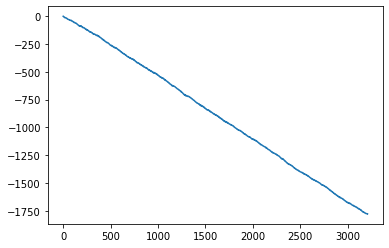

In [45]:
balance = 0
xs = np.array(races_train['datetime'])
ys = []

for rid in tqdm(races_train['rid']):
    balance -= 1
    
    if get_predicted_winner(horses_clean[horses_clean['rid'] == rid]) == rid_to_winner[rid]:
        df = horses_clean[horses_clean['rid'] == rid]
        balance += (1 / horses_clean[
            (horses_clean['rid'] == rid) & (horses_clean['horseName'] == rid_to_winner[rid])
        ].iloc[0]['decimalPrice']) / 2
        
    ys.append(balance)
    
plt.plot(np.arange(len(ys)), ys)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1012/1012 [00:05<00:00, 194.55it/s]


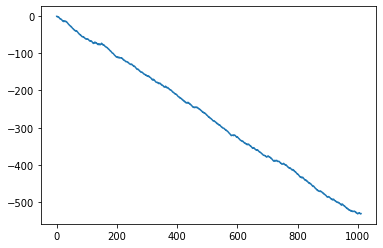

In [46]:
balance = 0
xs = np.array(races_dev['datetime'])
ys = []

for rid in tqdm(races_dev['rid']):
    balance -= 1
    
    if get_predicted_winner(horses_clean[horses_clean['rid'] == rid]) == rid_to_winner[rid]:
        df = horses_clean[horses_clean['rid'] == rid]
        balance += (1 / horses_clean[
            (horses_clean['rid'] == rid) & (horses_clean['horseName'] == rid_to_winner[rid])
        ].iloc[0]['decimalPrice']) / 2
        
    ys.append(balance)
    
plt.plot(np.arange(len(ys)), ys)

---